# SFUGDA - hidden structure mining

Based on *Exploiting the Intrinsic Neighborhood Structure for Source-free Domain Adaptation*

$$
L_{struc} = -\frac{1}{n_t}\sum_i \sum_{k \in N_i}P_k'P_i\\
L_{semantic} = -\frac{1}{n_t}\sum_i \sum_{k \in N_i}A_{ik}P_k'P_i\\
\begin{aligned}&A_{i,j}=\begin{cases}1&\text{if }j\in\mathcal{N}_K^i\wedge i\in\mathcal{N}_M^j\\r&\text{otherwise.}\end{cases}\end{aligned}\\
L_{div} = KL(\bar{p}_c||q_c)=\sum_{c=0}^1\bar{p}_c log(\frac{\bar{p}_c}{q_c})\\
q_0=1-\alpha,q_1=\alpha,\bar{p}_c=\frac1{n_t}\sum_i^{n_t}p_i^c\\
L = L_{struc} + L_{semantic}+L_{div}
$$
    

In [1]:
from utils import *
from sup_models import *
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.utils import to_undirected
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import os
from pygod.metric import eval_roc_auc

device = torch.device('cuda:0')
set_random_seeds(seed_value=123, device=device)

## Res to Hotel

In [2]:
data_tgt, label_tgt = load_data('YelpHotel', if_split=False)
data_tgt, label_tgt = data_tgt.to(device), label_tgt.to(device)
with open(f"structure_data/YelpHotel.txt", 'rb') as f:
        structure_link = torch.tensor(pickle.load(f))
edge_idx = to_undirected(structure_link, data_tgt.x.shape[0]).to(device)
G = nx.Graph()
G.add_edges_from(edge_idx.t().tolist())
adj_struc = torch.tensor(nx.to_numpy_array(G, dtype=int)).to(device).float()

In [3]:
set_random_seeds(123,device='gpu')

encoder = GCN_Encoder(nhids=[8000,128,64],dropout=0.,with_bn=False).to(device)
classifier = Classifier(nhids=[64,32,1],dropout=0.,with_bn=False).to(device)
encoder.load_state_dict(torch.load('./saved/models_sup_H2R/GCN_encoder_202407241318.pth'))
classifier.load_state_dict(torch.load('./saved/models_sup_H2R/GCN_classifier_202407241318.pth'))

# for p in encoder.parameters():
#     p.requires_grad = False
for p in classifier.parameters():
    p.requires_grad = False

n_t = data_tgt.x.shape[0]
n_epoch = 300
k = 10  # 节点自己的topk
m = 10  # 其他节点的topm
alpha = 0.05  # 先验分布
encoder_optimizer = optim.Adam(params=encoder.parameters())
# classifier_optimizer = optim.Adam(params=classifier.parameters())

loss_div_list = []
loss_struc_list = []
loss_semantic_list = []


for epoch in tqdm(range(n_epoch)):
    emb = encoder(data_tgt.x, data_tgt.edge_index).to(device)
    emb_norm = torch.norm(emb,dim=1).to(device)

    cosine_sim = (emb @ emb.T) / emb_norm / emb_norm.unsqueeze(dim=1)
    indices_k = cosine_sim.topk(k+1, dim=1).indices # 因为会把自己算进去所以k+1，后面剔除
    indices_m = cosine_sim.topk(m+1, dim=1).indices

    adj_cos_k = torch.zeros([n_t,n_t]).to(device)
    adj_cos_k.scatter_(1, indices_k, 1.) # 生成邻接矩阵
    adj_cos_k -= torch.diag(torch.diag(adj_cos_k)) # 对角线归零
    adj_cos_m = torch.zeros([n_t,n_t]).to(device)
    adj_cos_m.scatter_(1, indices_m, 1.)
    adj_cos_m -= torch.diag(torch.diag(adj_cos_m))
    adj_cos = adj_cos_k * adj_cos_m # 只有互为邻居才算做邻居

    pred = classifier(emb)
    pred = torch.cat([1-pred,pred],dim=1).to(device)

    q = torch.tensor([1-alpha, alpha]).to(device)
    p = pred.mean(dim=0)
    
    loss_div = (p * torch.log(p/q)).sum()
    loss_struc = - ((adj_struc @ pred) * pred).sum(dim=1).mean()
    loss_semantic = - ((adj_cos @ pred) * pred).sum(dim=1).mean()
    loss = 500*loss_div + loss_struc/10 + loss_semantic

    encoder_optimizer.zero_grad()
    loss.backward()
    encoder_optimizer.step()

    loss_div_list.append(loss_div.detach().item())
    loss_struc_list.append(loss_struc.detach().item())
    loss_semantic_list.append(loss_semantic.detach().item())


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:13<00:00, 22.03it/s]


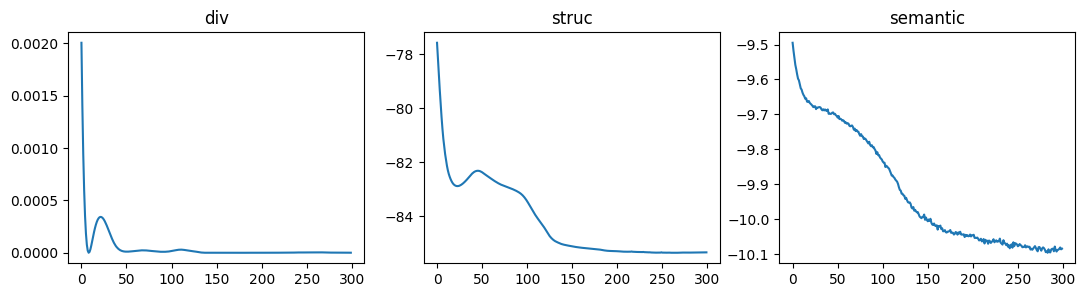

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))

axs[0].plot(loss_div_list)
axs[0].set_title('div')
axs[1].plot(loss_struc_list)
axs[1].set_title('struc')
axs[2].plot(loss_semantic_list)
axs[2].set_title('semantic')
plt.show()

In [5]:
from pygod.metric import eval_roc_auc
eval_roc_auc(label_tgt.detach().cpu().flatten(), pred[:,1].detach().cpu().flatten())

0.889630648330059

In [6]:
savedir = 'saved/models_SFUDA_hiddenstruc'
torch.save(encoder.state_dict(), os.path.join(savedir,f'R2H_encoder.pth'))
torch.save(classifier.state_dict(), os.path.join(savedir,f'R2H_classifier.pth'))

Res to Hotel:

* GCN Baseline: 0.618 
* DA: 0.890

---

## Hotel to Res

In [3]:
data_tgt, label_tgt = load_data('YelpRes', if_split=False)
data_tgt, label_tgt = data_tgt.to(device), label_tgt.to(device)
with open(f"structure_data/YelpRes.txt", 'rb') as f:
        structure_link = torch.tensor(pickle.load(f))
edge_idx = to_undirected(structure_link, data_tgt.x.shape[0]).to(device)
G = nx.Graph()
G.add_edges_from(edge_idx.t().tolist())
adj_struc = torch.tensor(nx.to_numpy_array(G, dtype=int)).to(device).float()

In [4]:
set_random_seeds(123,device='gpu')

encoder = GCN_Encoder(nhids=[8000,128,64],dropout=0.,with_bn=False).to(device)
classifier = Classifier(nhids=[64,32,1],dropout=0.,with_bn=False).to(device)
encoder.load_state_dict(torch.load('./saved/models_sup_R2H/GCN_encoder_202407241321.pth'))
classifier.load_state_dict(torch.load('./saved/models_sup_R2H/GCN_classifier_202407241321.pth'))

# for p in encoder.parameters():
#     p.requires_grad = False
for p in classifier.parameters():
    p.requires_grad = False

n_t = data_tgt.x.shape[0]
n_epoch = 300
k = 10  # 节点自己的topk
m = 10  # 其他节点的topm
alpha = 0.05  # 先验分布
encoder_optimizer = optim.Adam(params=encoder.parameters())
# classifier_optimizer = optim.Adam(params=classifier.parameters())

loss_div_list = []
loss_struc_list = []
loss_semantic_list = []


for epoch in tqdm(range(n_epoch)):
    emb = encoder(data_tgt.x, data_tgt.edge_index).to(device)
    emb_norm = torch.norm(emb,dim=1).to(device)

    cosine_sim = (emb @ emb.T) / emb_norm / emb_norm.unsqueeze(dim=1)
    indices_k = cosine_sim.topk(k+1, dim=1).indices # 因为会把自己算进去所以k+1，后面剔除
    indices_m = cosine_sim.topk(m+1, dim=1).indices

    adj_cos_k = torch.zeros([n_t,n_t]).to(device)
    adj_cos_k.scatter_(1, indices_k, 1.) # 生成邻接矩阵
    adj_cos_k -= torch.diag(torch.diag(adj_cos_k)) # 对角线归零
    adj_cos_m = torch.zeros([n_t,n_t]).to(device)
    adj_cos_m.scatter_(1, indices_m, 1.)
    adj_cos_m -= torch.diag(torch.diag(adj_cos_m))
    adj_cos = adj_cos_k * adj_cos_m # 只有互为邻居才算做邻居

    pred = classifier(emb)
    pred = torch.cat([1-pred,pred],dim=1).to(device)

    q = torch.tensor([1-alpha, alpha]).to(device)
    p = pred.mean(dim=0)
    
    loss_div = (p * torch.log(p/q)).sum()
    loss_struc = - ((adj_struc @ pred) * pred).sum(dim=1).mean()
    loss_semantic = - ((adj_cos @ pred) * pred).sum(dim=1).mean()
    loss = 500*loss_div + loss_struc/50 + loss_semantic

    encoder_optimizer.zero_grad()
    loss.backward()
    encoder_optimizer.step()

    loss_div_list.append(loss_div.detach().item())
    loss_struc_list.append(loss_struc.detach().item())
    loss_semantic_list.append(loss_semantic.detach().item())


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:16<00:00, 18.43it/s]


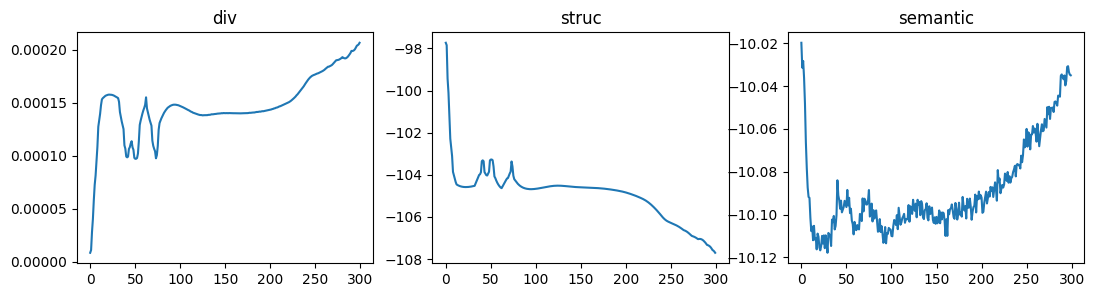

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))

axs[0].plot(loss_div_list)
axs[0].set_title('div')
axs[1].plot(loss_struc_list)
axs[1].set_title('struc')
axs[2].plot(loss_semantic_list)
axs[2].set_title('semantic')
plt.show()

In [6]:
eval_roc_auc(label_tgt.detach().cpu().flatten(), pred[:,1].detach().cpu().flatten())

0.9947660646787064

In [7]:
pred_cpu = pred[:,1].detach().cpu().flatten()

In [9]:
(pred_cpu>0.5).sum()

tensor(231)

In [19]:
((pred_cpu>0.5) == label_tgt.flatten().cpu()).numpy().mean()

0.9954110135674381

In [22]:
savedir = 'saved/models_SFUDA_hiddenstruc'
torch.save(encoder.state_dict(), os.path.join(savedir,f'H2R_encoder.pth'))
torch.save(classifier.state_dict(), os.path.join(savedir,f'H2R_classifier.pth'))

Hotel to Res:

* GCN Baseline: 0.820 
* DA: 0.995